<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/wganworkking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [42]:
def make_generator_model():
    input_noise = layers.Input(shape=(100,))
    noise = layers.Dense(7*7*64)(input_noise)
    noise = layers.Reshape((7, 7, 64))(noise)

    input_digit = layers.Input(shape=(1,))
    digit = layers.Embedding(10, 49)(input_digit)
    digit = layers.Reshape((7, 7, 1))(digit)

    x = layers.concatenate([noise, digit])

    x = layers.Conv2DTranspose(128,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.BatchNormalization()(x)

    x = layers.Conv2DTranspose(128,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(1,3,1,padding='same',activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=(input_noise,input_digit), outputs=x)
    model.summary()
    return model


def make_discriminator_model():
    input_img = layers.Input(shape=(28,28,1))

    input_digit = layers.Input(shape=(1,))
    digit = layers.Embedding(10, 5)(input_digit)
    digit = layers.Flatten()(digit)
    #digit = layers.Reshape((28, 28, 1))(digit)



    x = layers.Conv2D(64,5,2,padding='same',activation='LeakyReLU')(input_img)


    x = layers.Conv2D(64,3,2,padding='same',activation='LeakyReLU')(x)


    x = layers.Conv2D(64,3,2,padding='same',activation='LeakyReLU')(x)


    x = layers.Conv2D(64,3,2,padding='same',activation='LeakyReLU')(x)


    x = layers.Flatten()(x)

    x = layers.concatenate([x, digit])

    dense_output = layers.Dense(128, activation='LeakyReLU')(x)



    dense_output = layers.Dense(64, activation='LeakyReLU')(x)


    dense_output = layers.Dense(1, activation=None)(dense_output)

    model = tf.keras.models.Model(inputs=(input_img,input_digit), outputs=dense_output)
    return model



In [36]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [303]:
generator = make_generator_model()
generator_optimizer = tf.keras.optimizers.Adam(0.0004)

Model: "model_50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_109 (InputLayer)      [(None, 100)]                0         []                            
                                                                                                  
 input_110 (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 dense_110 (Dense)           (None, 3136)                 316736    ['input_109[0][0]']           
                                                                                                  
 embedding_54 (Embedding)    (None, 1, 49)                490       ['input_110[0][0]']           
                                                                                           

In [304]:
discriminatorW = make_discriminator_model()
discriminatorW_optimizer = tf.keras.optimizers.Adam(0.0004)

In [305]:
discriminatorU = make_discriminator_model()
discriminatorU_optimizer = tf.keras.optimizers.Adam(0.0003)

In [306]:
BATCH_SIZE = 64

@tf.function
def discriminator_lossW(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = fake_loss - real_loss
    return total_loss

@tf.function
def generator_lossW(fake_output):
    return -tf.reduce_mean(fake_output)

@tf.function
def gradient_penalty(real_images, fake_images,digits):
    alpha = tf.random.uniform([BATCH_SIZE, 1, 1, 1], 0., 1.)
    real_images, fake_images = tf.cast(real_images, tf.float32), tf.cast(fake_images, tf.float32)
    interpolated_images = alpha * real_images + ((1 - alpha) * fake_images)
    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        pred = discriminatorW((interpolated_images,digits), training=True)
    gradients = tape.gradient(pred, [interpolated_images])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

In [307]:

@tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

@tf.function
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

In [232]:
NOISE_DIM = 100

@tf.function
def train_step(real_images,digits):
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        # Generate random noise
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

        # Generate fake images with the generator
        generated_images = generator((noise,digits), training=True)

        # Discriminator loss calculation
        real_output = discriminatorU((real_images,digits), training=True)
        fake_output = discriminatorU((generated_images,digits), training=True)
        d_loss = discriminator_loss(real_output, fake_output)

        # Generator loss calculation
        g_loss = generator_loss(fake_output)

    # Update generator and discriminator variables
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminatorU.trainable_variables)
    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    discriminatorU_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminatorU.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    tf.print("disc_loss",d_loss,'gen_loss',g_loss)

In [308]:
NOISE_DIM = 100

#@tf.function
def train_step(real_images,digits):

    for i in range(5):
      with tf.GradientTape() as disc_tape:
        # Generate random noise
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

        # Generate fake images with the generator
        generated_images = generator((noise,digits), training=True)

        # Discriminator loss calculation
        real_output = discriminatorU((real_images,digits), training=True)
        fake_output = discriminatorU((generated_images,digits), training=True)
        d_loss = discriminator_loss(real_output, fake_output)


      gradients_of_discriminator = disc_tape.gradient(d_loss, discriminatorU.trainable_variables)
      discriminatorU_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminatorU.trainable_variables))

      if i == 0:
        weights = discriminatorU.get_weights()

    with tf.GradientTape() as gen_tape:
      # Generate random noise
      noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

      # Generate fake images with the generator
      generated_images = generator((noise,digits), training=True)

      fake_output = discriminatorU((generated_images,digits), training=True)

       # Generator loss calculation
      g_loss = generator_loss(fake_output)

    # Update generator and discriminator variables

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    discriminatorU.set_weights(weights)

    tf.print("disc_loss",d_loss,'gen_loss',g_loss)

In [259]:
NOISE_DIM = 100
GP_WEIGHT = 10


@tf.function
def train_step(images,digits):


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tapeW:
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        generated_images = generator((noise,digits), training=True)

        real_outputW = discriminatorW((images,digits), training=True)
        fake_outputW = discriminatorW((generated_images,digits), training=True)

        disc_lossW = discriminator_lossW(real_outputW, fake_outputW)

        gen_lossW = generator_lossW(fake_outputW)
        gen_loss = gen_lossW

        gp = gradient_penalty(images, generated_images, digits)
        disc_lossW += gp * GP_WEIGHT



    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    gradients_of_discriminatorW = disc_tapeW.gradient(disc_lossW, discriminatorW.trainable_variables)
    discriminatorW_optimizer.apply_gradients(zip(gradients_of_discriminatorW, discriminatorW.trainable_variables))


    tf.print("disc_lossW",disc_lossW,'gen_lossW',gen_lossW)

In [309]:
def train(dataset,y_train, epochs):
  for epoch in range(epochs):
    for batch in range(len(dataset) // BATCH_SIZE):

            target_images = dataset[batch * BATCH_SIZE: (batch+1) * BATCH_SIZE]
            digits = y_train[batch * BATCH_SIZE: (batch+1) * BATCH_SIZE]

            train_step(target_images,digits)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      print(epoch)



In [ ]:
EPOCHS = 100
x_train2 = np.expand_dims(x_train, axis=-1)
x_train2 = (x_train2 - np.min(x_train2)) / (np.max(x_train2) - np.min(x_train2))
train(x_train2,y_train, EPOCHS)

disc_loss 0.121565267 gen_loss 4.41849


1/1 [==============================] - 0s 34ms/step
tf.Tensor([2], shape=(1,), dtype=int32)


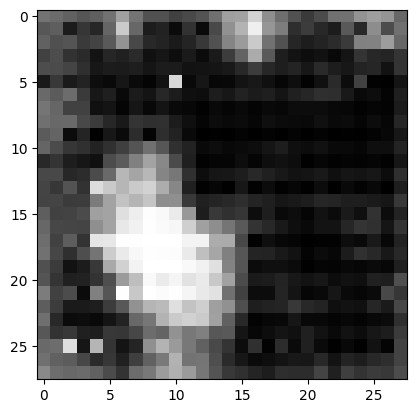

In [315]:
noise = tf.random.normal(shape=(1,100))
random_number = tf.random.uniform(shape=[1,], minval=0, maxval=10, dtype=tf.int32)
test = generator.predict((noise,random_number))
print(random_number)
plt.imshow(test.squeeze(), cmap='gray')
plt.show()

In [ ]:
NOISE_DIM = 100
GP_WEIGHT = 10


#@tf.function
def train_step(images,digits):


    for i in range(3):
      with tf.GradientTape() as disc_tapeU:
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        generated_images = generator((noise,digits), training=True)

        real_outputU = discriminatorU((images,digits), training=True)
        fake_outputU = discriminatorU((generated_images,digits), training=True)
        disc_lossU = cross_entropy(tf.ones_like(real_outputU), real_outputU)




      gradients_of_discriminatorU = disc_tapeU.gradient(disc_lossU, discriminatorU.trainable_variables)
      discriminatorU_optimizer.apply_gradients(zip(gradients_of_discriminatorU, discriminatorU.trainable_variables))
      if i == 0:
        weights = discriminatorU.get_weights()


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tapeW:
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
        generated_images = generator((noise,digits), training=True)

        real_outputW = discriminatorW((images,digits), training=True)
        fake_outputW = discriminatorW((generated_images,digits), training=True)
        real_outputU = discriminatorU((images,digits), training=True)
        fake_outputU = discriminatorU((generated_images,digits), training=True)
        disc_lossW = discriminator_lossW(real_outputW, fake_outputW)


        gen_lossU = cross_entropy(tf.ones_like(fake_outputU), fake_outputU)
        gen_lossW = generator_lossW(fake_outputW)
        gen_loss = gen_lossU#+gen_lossW

        gp = gradient_penalty(images, generated_images, digits)
        disc_lossW += gp * GP_WEIGHT



    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    gradients_of_discriminatorW = disc_tapeW.gradient(disc_lossW, discriminatorW.trainable_variables)
    discriminatorW_optimizer.apply_gradients(zip(gradients_of_discriminatorW, discriminatorW.trainable_variables))

    discriminatorU.set_weights(weights)

    tf.print("disc_lossW",disc_lossW,'disc_lossU',disc_lossU,'gen_lossU',gen_lossU,'gen_lossW',gen_lossW)

In [ ]:
print(np.min(x_train2))